## Initial setup

Validate your python environment here.

In [31]:
import gzip
import os
import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rdkit
import rdkit.Chem
import rdkit.Chem.Draw
from scipy.stats import randint, uniform
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
import tensorflow as tf

from preprocessing.chemistry import (
    convert_smiles_to_bits,
)
from preprocessing.preprocessing import (
    create_target_variable,
    create_chemistry_features,
)


Specify some configurations for the notebook.

In [2]:
DOWNLOAD_DIR = "datasets"

SOURCES = {
    "clintox": {
        "download_url": "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz",
        "file_name": "clintox.csv",
    },
    "toxcast": {
        "download_url": "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/toxcast_data.csv.gz",
        "file_name": "toxcast.csv",
    },
    "pcba": {
        "download_url": "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/pcba.csv.gz",
        "file_name": "pcba.csv",
    },
}

Now we'll define some data loading helpers:
- `fetch_data` downloads a local copy of the files specified in `SOURCES` above.
- `load_data(name)` returns a dataframe that was extracted from the downloaded file.

Example usages can be seen below.

In [3]:
# We'll maintain a global cache of dataframes to avoid re-loading them
global DATA_CACHE
DATA_CACHE = {}


def fetch_data(source, force_redownload=False):
    # create storage path if it does not exist
    storage_path = os.path.join(DOWNLOAD_DIR, source)
    if not os.path.isdir(storage_path):
        os.makedirs(storage_path)

    # download file if it does not exist or if we want a fresh copy
    gz_file_path = os.path.join(storage_path, f"{SOURCES[source]['file_name']}.gz") 
    if not os.path.isfile(gz_file_path) or force_redownload:
        urllib.request.urlretrieve(SOURCES[source]["download_url"], gz_file_path)


def load_data(name):
    file_path = os.path.join(DOWNLOAD_DIR, name, SOURCES[name]["file_name"])

    # check if we've already loaded this data
    global DATA_CACHE
    if name in DATA_CACHE:
        return DATA_CACHE[name]

    # extract csv if we haven't already
    gz_file_path = f"{file_path}.gz"
    if not os.path.isfile(file_path):
        with gzip.open(gz_file_path, "rb") as f_in:
            with open(file_path, "wb") as f_out:
                f_out.write(f_in.read())

    data = pd.read_csv(file_path)

    if name == "clintox":
        # # query for rows
        # data = data.query('''
        #     NOTE query goes here
        # ''').reset_index()
        pass        
    elif name == "toxcast":
        # # query for rows
        # data = data.query('''
        #     NOTE query goes here
        # ''').reset_index()
        pass
    elif name == "pcba":
        # # query for rows
        # data = data.query('''
        #     NOTE query goes here
        # ''').reset_index()
        pass

    # mark the data with the source so we can tell where it came from
    data["source"] = name

    DATA_CACHE[name] = data
    return data


In [4]:
for source in SOURCES:
    fetch_data(source, force_redownload=False)

## Exploration

Define some helpers for displaying molecules

In [4]:
def random_smiles():
    clintox_data = load_data("clintox")
    return clintox_data["smiles"][np.random.randint(len(clintox_data))]


def display_molecule(molecule):
    print(molecule)
    return rdkit.Chem.Draw.MolToImage(rdkit.Chem.MolFromSmiles(molecule))


Starting with some basic inspection

In [5]:
load_data("clintox").head()

,smiles,FDA_APPROVED,CT_TOX,source
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0,clintox
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0,clintox
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0,clintox
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0,clintox
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0,clintox


In [6]:
load_data("clintox").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   smiles        1484 non-null   object
 1   FDA_APPROVED  1484 non-null   int64 
 2   CT_TOX        1484 non-null   int64 
 3   source        1484 non-null   object
dtypes: int64(2), object(2)
memory usage: 46.5+ KB


In [7]:
load_data("toxcast").head()

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up,source
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,toxcast
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,toxcast
2,CN1CCN(CC1)C(=O)C1CCCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,toxcast
3,NC1=CC=C(C=C1)[N+]([O-])=O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,toxcast
4,OC1=CC=C(C=C1)[N+]([O-])=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,toxcast


In [8]:
load_data("toxcast").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8597 entries, 0 to 8596
Columns: 619 entries, smiles to source
dtypes: float64(617), object(2)
memory usage: 40.6+ MB


In [9]:
load_data("pcba").head()

,PCBA-1030,PCBA-1379,PCBA-1452,PCBA-1454,PCBA-1457,PCBA-1458,PCBA-1460,PCBA-1461,PCBA-1468,PCBA-1469,...,PCBA-915,PCBA-924,PCBA-925,PCBA-926,PCBA-927,PCBA-938,PCBA-995,mol_id,smiles,source
0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID1511280,CC(=O)N1CCC2(CC1)NC(=O)N(c1ccccc1)N2,pcba
1,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID332939,N#Cc1nnn(-c2ccc(Cl)cc2)c1N,pcba
2,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID3800322,COC(=O)c1ccc(NC(=O)c2ccccc2CC[N+](=O)[O-])cc1,pcba
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID46904422,CCC1NC(=O)c2cccnc2-n2c1nc1ccc(F)cc1c2=O,pcba
4,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID16445987,CC1=CC(=O)/C(=C2/C=C(C(=O)Nc3ccc(S(=O)(=O)Nc4o...,pcba


In [10]:
load_data("pcba").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437929 entries, 0 to 437928
Columns: 131 entries, PCBA-1030 to source
dtypes: float64(128), object(3)
memory usage: 437.7+ MB


It could help to get a better understanding of the SMILES format by comparing it to the actual molecule. Running this cell will give you a comparison for a random molecule in the toxcast dataset.

CC(C)(C)[NH2+]CC(c1ccc(c(n1)CO)O)O


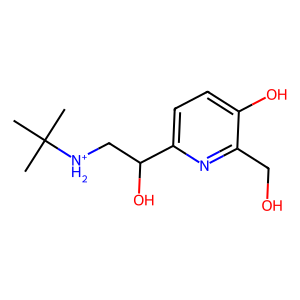

In [5]:
smiles_mol = random_smiles()

display_molecule(smiles_mol)

Let's see what this molecule looks like when one-hot encoded...

In [20]:
convert_smiles_to_bits(smiles_mol)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

## Predicting Toxicity

Define some helpers for training and validating models

In [6]:
def partition_data(data, n_splits, split_size):
    remaining_size, splits = 1.0, []
    
    for _ in range(n_splits):
        remaining, split = train_test_split(
            data,
            test_size=split_size/remaining_size,
            random_state=123,
        )
        splits.append(split)

        remaining_size -= split_size
        data = remaining

    return [remaining, *splits]


def get_features_and_labels(data, label_column_name="toxicity_target"):
    return dict(
        features=data.drop(label_column_name, axis=1).copy(),
        labels=data[label_column_name].copy(),
    )


def analyze_hyperparameters(X, y, classifier, param_grid, figsize=(8, 8)):
    scoring_methods = [
        "accuracy", "precision", "recall", "balanced_accuracy", "f1",
    ]

    fig, axs = plt.subplots(
        nrows=len(scoring_methods),
        ncols=len(param_grid),
        figsize=figsize,
    )
    axs = axs.ravel()

    for i, scoring_method in enumerate(scoring_methods):
        print(f"Scoring: {scoring_method+'...':<21}", end="")
        for j, param_name in enumerate(param_grid):
            grid = GridSearchCV(
                classifier,
                param_grid={param_name: param_grid[param_name]},
                scoring=scoring_method,
                n_jobs=-1,
            )
            grid.fit(X, y)

            axs[len(param_grid)*i + j].plot(
                param_grid[param_name],
                grid.cv_results_['mean_test_score'],
                color=['red', 'darkgoldenrod', 'blue', 'purple', 'green'][i]
            )
            if (i == 0):
                axs[len(param_grid)*i + j].set_title(param_name)
            if (j == 0):
                axs[len(param_grid)*i + j].set_ylabel(scoring_method)

        print(f"Done {i+1}/{len(scoring_methods)}.")

    plt.tight_layout()
    plt.show()


def search_and_validate(X, y, X_val, y_val, classifier, param_grid, n_iter=20, scoring="f1"):
    grid = RandomizedSearchCV(
        classifier,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring=scoring,
        n_jobs=-1,
        random_state=123,
    )
    grid.fit(X, y)

    y_pred = grid.best_estimator_.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average='binary',
    )

    y_pred_val = grid.best_estimator_.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(
        y_val, y_pred_val, average='binary',
    )

    print(f"Best parameters: {grid.best_params_}")
    print(f"Training score: {f1}")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"Validation score: {f1_val}")
    print(f"  Accuracy: {accuracy_val}")
    print(f"  Precision: {precision_val}")
    print(f"  Recall: {recall_val}")

    return grid


def rank_features_by_importance(classifier, X, n_features=20):
    try:
        feature_importances = classifier.feature_importances_
    except AttributeError:
        # logistic regression does not have feature_importances_
        feature_importances = classifier.coef_[0]

    indices = np.argsort(feature_importances)[::-1]

    print("Feature ranking:")
    for f in range(min(X.shape[1], n_features)):
        print(f"{f+1}. {X.columns[indices[f]]} ({feature_importances[indices[f]]})")


### Preprocessing

These will be the pieces that make up our pipeline

In [7]:
class _Base(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X


class GenerateToxicity(_Base):
    def transform(self, X, y=None):
        _X = X.copy()

        if _X["source"][0] == "clintox":
            _X["toxicity_target"] = _X["CT_TOX"]
        elif _X["source"][0] == "toxcast":
            create_target_variable(_X)
        elif _X["source"][0] == "pcba":
            create_target_variable(_X)
        
        return _X


class ColumnCleaner(_Base):
    def transform(self, X, y=None):
        return X[["smiles", "toxicity_target"]]


class DropInvalidSmiles(_Base):
    def transform(self, X, y=None):
        _X = X.copy()

        _X["molecule"] = _X["smiles"].apply(rdkit.Chem.MolFromSmiles)
        _X = _X[~_X["molecule"].isna()]
        _X = _X.drop(columns=["molecule"])

        return _X


class SmilesToBits(_Base):
    def transform(self, X, y=None):
        bits = 256

        vectorized_smiles_to_bits = np.vectorize(
            convert_smiles_to_bits,
            otypes=[np.ndarray],
            excluded={"bits"},
        )

        _X = pd.DataFrame(
            np.stack(
                vectorized_smiles_to_bits(X["smiles"], bits=bits)
            ).reshape(X.shape[0], bits),
            columns=[f"fingerprint_{i}" for i in range(bits)],
        )
        _X["toxicity_target"] = X["toxicity_target"]        
        _X.reset_index(drop=True, inplace=True)

        return _X


class ToxicInt(_Base):
    def transform(self, X, y=None):
        _X = X.copy()
        _X["toxicity_target"] = _X["toxicity_target"].apply(lambda x: 1 if x else 0)
        return _X

In [8]:
pipeline = Pipeline(
    [
        ("generate_toxicity", GenerateToxicity()),
        ("clean_columns", ColumnCleaner()),
        ("drop_invalid", DropInvalidSmiles()),
        ("smiles_to_bits", SmilesToBits()),
        ("toxic_int", ToxicInt()),
    ]
)

prepped_clintox = pipeline.fit_transform(load_data("clintox"))
prepped_toxcast = pipeline.fit_transform(load_data("toxcast"))
prepped_pcba = pipeline.fit_transform(load_data("pcba"))

prepped_data = pd.concat([prepped_clintox, prepped_toxcast, prepped_pcba])

[20:23:37] Explicit valence for atom # 0 N, 5, is greater than permitted
[20:23:37] Can't kekulize mol.  Unkekulized atoms: 9
[20:23:37] Explicit valence for atom # 10 N, 4, is greater than permitted
[20:23:37] Explicit valence for atom # 10 N, 4, is greater than permitted
[20:23:37] Can't kekulize mol.  Unkekulized atoms: 4
[20:23:37] Can't kekulize mol.  Unkekulized atoms: 4
[20:23:38] Explicit valence for atom # 0 F, 2, is greater than permitted
[20:23:38] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[20:23:38] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[20:23:38] WARNING: not removing hydrogen atom without neighbors
[20:23:38] Explicit valence for atom # 3 Si, 8, is greater than permitted
[20:23:38] Explicit valence for atom # 3 Si, 8, is greater than permitted
[20:23:38] SMILES Parse Error: syntax error while parsing: FAIL
[20:23:38] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[20:23:38] SMILES Parse Error: syntax error 

In [9]:
prepped_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447984 entries, 0 to 437928
Columns: 257 entries, fingerprint_0 to toxicity_target
dtypes: int32(256), int64(1)
memory usage: 444.3 MB


In [10]:
print(len(prepped_data))
print(prepped_data["toxicity_target"].value_counts(normalize=True))


447984
0    0.574904
1    0.425096
Name: toxicity_target, dtype: float64


In [11]:
train_data, val_data, test_data = partition_data(prepped_data, 2, 0.15)

print(len(train_data))
print(train_data["toxicity_target"].value_counts(normalize=True))
print('----')
print(len(val_data))
print(val_data["toxicity_target"].value_counts(normalize=True))
print('----')
print(len(test_data))
print(test_data["toxicity_target"].value_counts(normalize=True))


313588
0    0.574847
1    0.425153
Name: toxicity_target, dtype: float64
----
67198
0    0.577785
1    0.422215
Name: toxicity_target, dtype: float64
----
67198
0    0.572294
1    0.427706
Name: toxicity_target, dtype: float64


In [12]:
X_train, y_train = get_features_and_labels(train_data).values()
X_val, y_val = get_features_and_labels(val_data).values()
X_test, y_test = get_features_and_labels(test_data).values()

In [16]:
y_train.iloc[0:5000].value_counts(normalize=True)

0    0.5766
1    0.4234
Name: toxicity_target, dtype: float64

### Tuning and testing RandomForestClassifier

Scoring: accuracy...          Done 1/5.
Scoring: precision...         Done 2/5.
Scoring: recall...            Done 3/5.
Scoring: balanced_accuracy... Done 4/5.
Scoring: f1...                Done 5/5.


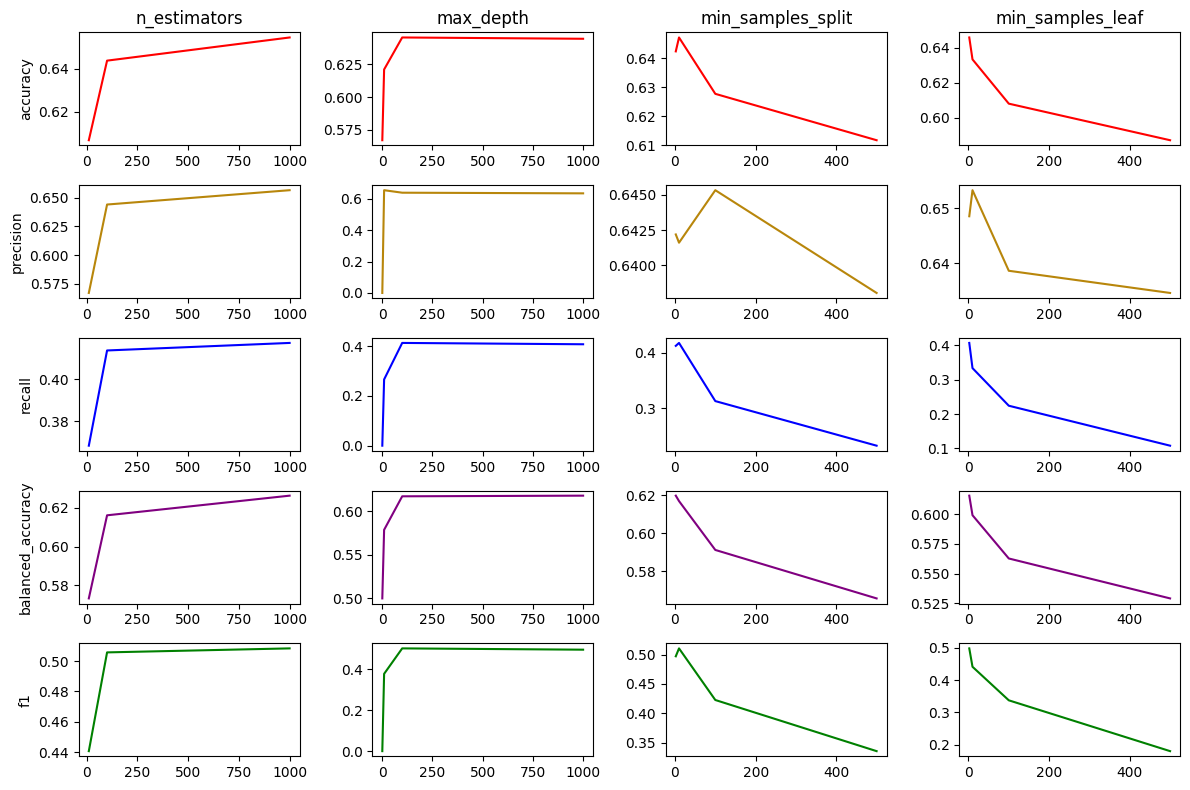

In [17]:
analyze_hyperparameters(
    X_train.iloc[0:25000], y_train.iloc[0:25000],
    classifier=RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 100, 1000],
        "max_depth": [1, 10, 100, 1000],
        "min_samples_split": [2, 10, 100, 500],
        "min_samples_leaf": [2, 10, 100, 500],
    },
    figsize=(12, 8),
)

In [18]:
grid = search_and_validate(
    X_train, y_train,
    X_val, y_val,
    classifier=RandomForestClassifier(),
    param_grid={
        "n_estimators": randint(75, 200),
        "max_depth": randint(50, 100),
        "min_samples_split": randint(2, 100),
        "min_samples_leaf": randint(2, 75),
    },
    n_iter=20,
)

# Best parameters: {'max_depth': 76, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 191}

Best parameters: {'max_depth': 76, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 191}
Training score: 0.7664515464625313
  Accuracy: 0.8264346850007016
  Precision: 0.8955627976936575
  Recall: 0.6698769154609482
Validation score: 0.5696985203189631
  Accuracy: 0.6996636804666806
  Precision: 0.7209929843497032
  Recall: 0.47088678979275345


In [19]:
rank_features_by_importance(grid.best_estimator_, X_train, n_features=20)

Feature ranking:
1. fingerprint_138 (0.0174960221853508)
2. fingerprint_125 (0.0140611176745344)
3. fingerprint_41 (0.013269497189227401)
4. fingerprint_80 (0.011973685580144555)
5. fingerprint_39 (0.010381855043472688)
6. fingerprint_158 (0.01025386733705454)
7. fingerprint_97 (0.009856796987284738)
8. fingerprint_251 (0.009755236528707968)
9. fingerprint_107 (0.009575103440677265)
10. fingerprint_182 (0.008513707046584603)
11. fingerprint_122 (0.008489133814414823)
12. fingerprint_58 (0.008476811469268215)
13. fingerprint_63 (0.008407396521833749)
14. fingerprint_162 (0.008076321257807459)
15. fingerprint_197 (0.008060373280110621)
16. fingerprint_167 (0.007823710687347009)
17. fingerprint_186 (0.007785238338554393)
18. fingerprint_163 (0.007774608887898776)
19. fingerprint_175 (0.007653401078018347)
20. fingerprint_128 (0.007311746338908255)


In [24]:
y_pred = grid.best_estimator_.predict(X_test)

print(f"""
Accuracy: {accuracy_score(y_test, y_pred)}
Precision: {precision_score(y_test, y_pred)}
Recall: {recall_score(y_test, y_pred)}
F1: {f1_score(y_test, y_pred)}
""")


Accuracy: 0.6965683502485193
Precision: 0.7242360775468557
Recall: 0.46922514874221494
F1: 0.5694860858916431



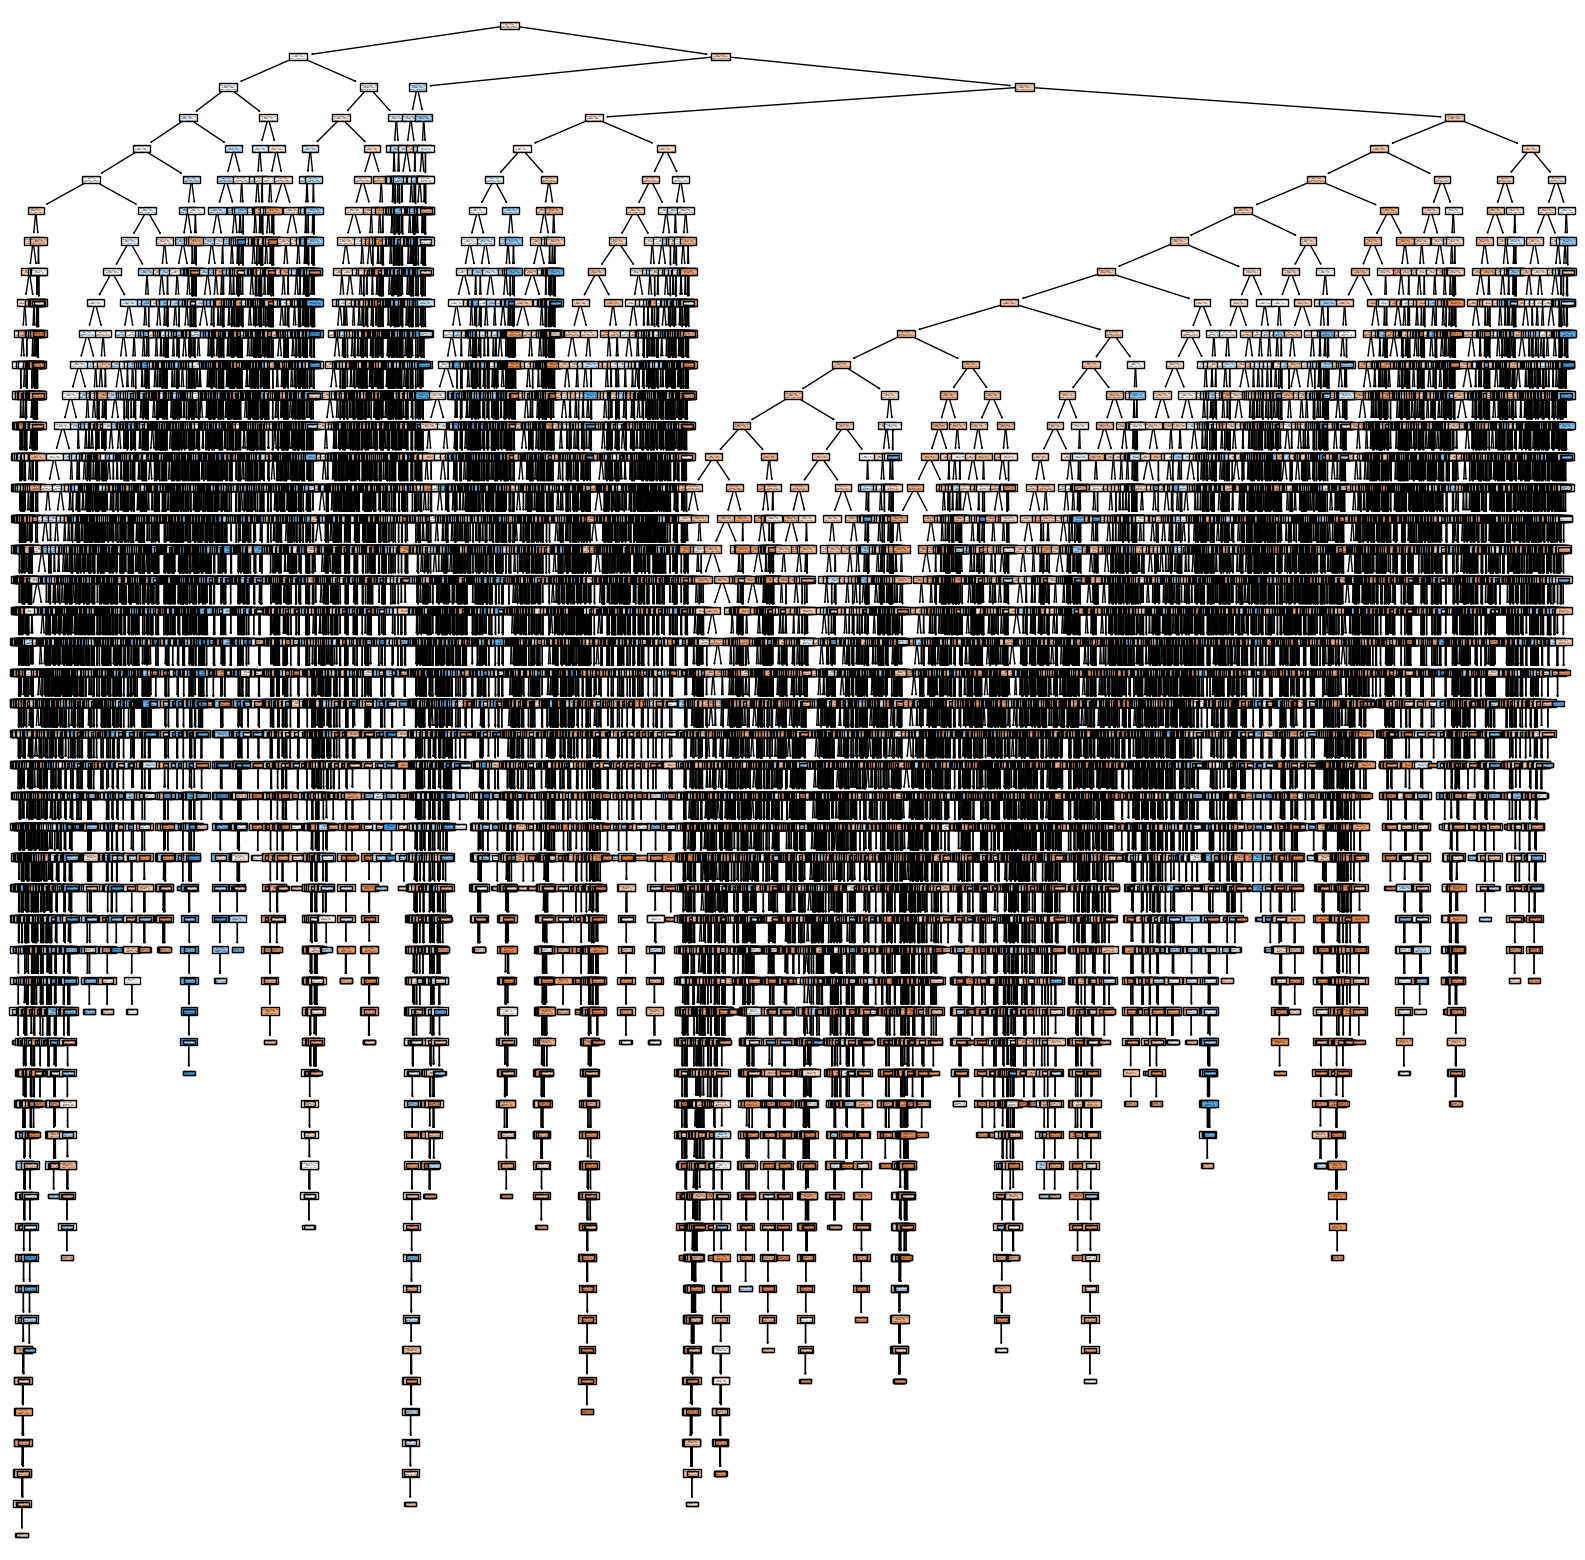

In [26]:
plt.figure(figsize=(20, 20))
plot_tree(grid.best_estimator_.estimators_[0], feature_names=X_train.columns, filled=True)
plt.show()

### Training and testing a Neural Network

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


c:\Users\Dmitry\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [21]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [28]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1,
)

y_pred = model.predict(X_val)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(f"""
Accuracy: {accuracy_score(y_val, y_pred)}
Precision: {precision_score(y_val, y_pred)}
Recall: {recall_score(y_val, y_pred)}
F1: {f1_score(y_val, y_pred)}
""")

# Previous best:
#     Accuracy: 0.5692728950266377
#     Precision: 0.49609990393852066
#     Recall: 0.4492188859121116
#     F1: 0.4714969141438118

# New best:
#     Accuracy: 0.5942885204916813
#     Precision: 0.5243460499439943
#     Recall: 0.5537733551372603
#     F1: 0.5386580929012608


Epoch 1/10
9800/9800 [==============================] - 15s 1ms/step - loss: 0.4424 - precision_1: 0.7823 - recall_1: 0.7057 - val_loss: 0.6573 - val_precision_1: 0.6486 - val_recall_1: 0.5578
Epoch 2/10
9800/9800 [==============================] - 14s 1ms/step - loss: 0.4314 - precision_1: 0.7900 - recall_1: 0.7134 - val_loss: 0.6699 - val_precision_1: 0.6316 - val_recall_1: 0.5973
Epoch 3/10
9800/9800 [==============================] - 14s 1ms/step - loss: 0.4225 - precision_1: 0.7957 - recall_1: 0.7199 - val_loss: 0.6907 - val_precision_1: 0.6322 - val_recall_1: 0.5824
Epoch 4/10
9800/9800 [==============================] - 15s 2ms/step - loss: 0.4132 - precision_1: 0.8008 - recall_1: 0.7286 - val_loss: 0.6989 - val_precision_1: 0.6395 - val_recall_1: 0.5748
Epoch 5/10
9800/9800 [==============================] - 15s 2ms/step - loss: 0.4045 - precision_1: 0.8060 - recall_1: 0.7356 - val_loss: 0.7133 - val_precision_1: 0.6322 - val_recall_1: 0.5922
Epoch 6/10
9800/9800 [=============

In [29]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(f"""
Accuracy: {accuracy_score(y_test, y_pred)}
Precision: {precision_score(y_test, y_pred)}
Recall: {recall_score(y_test, y_pred)}
F1: {f1_score(y_test, y_pred)}
""")


2100/2100 [==============================] - 2s 722us/step

Accuracy: 0.6717610643173904
Precision: 0.6310896681572135
Recall: 0.5597926307365784
F1: 0.5933069051350605

